# Analyzing Questions

One of the key advantages of our dataset is that the speakers of the testimonies are isolated. This means that we can identify specific sections of dialogue that are questions and investigate the types of questions that are posed, the lengths of those questions, and the frequency of questions across testimonies. This can tell us a lot about how testimonies differ in their structure.

In this notebook, we will learn how to use the testimonies quantitatively. We will do so through several different visualization methods.

## Importing the Required Libraries

For this notebook, we will be importing and working with the following libraries:

 - `datasets`: for loading our dataset from Hugging Face
 - `BeautifulSoup`: for parsing HTML content and extracting questions
 - `matplotlib`: for creating basic visualizations
 - `sentence_transformers`: for encoding questions into embeddings
 - `umap`: for dimensionality reduction of embeddings
 - `plotly`: for creating interactive visualizations
 - `pandas`: for data manipulation and analysis

Let's go ahead and import these now.


In [38]:

from datasets import load_dataset
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# Import necessary libraries
from sentence_transformers import SentenceTransformer
import umap
import plotly.express as px
import pandas as pd

## Loading the Data

Now that we have our libraries imported, let's begin by loading the dataset from HuggingFace. For this, we can use the `load_dataset()` function from the `datasets` package.

In [39]:
# Load the dataset from Hugging Face
dataset = load_dataset("placingholocaust/testimonies-1k", split="train")

Now that we have the dataset downloaded and loaded in memory, let's examine it.

In [40]:
dataset

Dataset({
    features: ['rg', 'html'],
    num_rows: 949
})

### Dataset Structure

The output above provides us with important information about the structure of our dataset:

1. **Features**: The dataset contains two features:
   - `rg`: Likely stands for "Record Group" or a similar identifier for each testimony.
   - `html`: Contains the HTML content of each testimony.

2. **Number of Rows**: There are 949 rows in the dataset, which means we have 949 individual testimonies to analyze.

This structure tells us that each row in our dataset represents a single testimony, with an identifier (`rg`) and the full HTML content of that testimony. The HTML content is particularly important as it contains the questions and answers that we'll be extracting and analyzing in our subsequent steps.

Let's examine a specific item in this dataset, we'll grab the first testimony and call this variable `sample_item`.

In [42]:
sample_item = dataset[0]

Now, let's examine the `html` field by exploring its length.

In [44]:
len(sample_item["html"])

429334

As we can see, the `html` is roughly 430,000 characters long. This is a fairly long testimony (about 183 typed pages). To demonstrate this, let's take  a look at all the questions in this testimony. To do that, we will want a function that can retrieve the dialogue tags that have a class of "Question".


This function takes HTML content as input and extracts all the questions from it.
Here's how it works:

1. It uses BeautifulSoup to parse the HTML content.
2. It finds all 'dialogue' tags with class 'Question' using soup.find_all().
3. For each question found, it extracts the text content using get_text().
4. It returns a list of all extracted questions, with whitespace stripped.


In [45]:
# Function to extract questions from HTML content
def extract_questions(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    questions = soup.find_all('dialogue', class_='Question')
    return [q.get_text(strip=True) for q in questions]


Now, we can grab all the questions and examine the quantity of them.

In [49]:
rg = sample_item['rg']
html_content = item['html']

questions = extract_questions(html_content)
print(f"There are {len(questions)} questions in this testimony.")

There are 1213 questions in this testimony.


As you can see, we have 1213 questions. Let's take a look at the first few questions.

In [48]:

print(f"Questions from testimony {rg}:")
for i, question in enumerate(questions[:5], 1):
    print(f"{i}. {question}")
print("\n")

Questions from testimony RG-50.030.0469_trs_en_cleaned:
1. Q: Good morning, Alice.
2. Q: Welcome, welcome to Washington, and Virginia.
3. Q: It's wonderful to have you here, finally, after all this time.
4. Q: Yes. Alice, tell me when you were born. What was the date of -- your date of birth.
5. Q: And where were you born?




## Examining Question Counts

One of the first things we may want to do is examine the quantity of questions across all our testimonies. We can do this by using the built-in math formulas in Python, such as `sum`, `max`, and `min`. 

In [52]:
# Count questions for each testimony
question_counts = []
for item in dataset:
    html_content = item['html']
    questions = extract_questions(html_content)
    question_counts.append(len(questions))

# Calculate statistics
avg_questions = sum(question_counts) / len(question_counts)
max_questions = max(question_counts)
min_questions = min(question_counts)

print(f"Average number of questions: {avg_questions:.2f}")
print(f"Maximum number of questions: {max_questions}")
print(f"Minimum number of questions: {min_questions}")
print(f"Total number of questions: {sum(question_counts)}")

Average number of questions: 202.16
Maximum number of questions: 1576
Minimum number of questions: 0
Total number of questions: 191849


This is useful information. We can clearly see that we have a total of roughly 200,000 questions across approximately 1,000 testimonies. We can see that the lowest testimonies have 0 questions. This is because these particular testimonies (of which there are 3) are structured in an inconsistent format. While most PDFs int his question clearly identify the questions and answers in modern-typed PDFs, these are typerwriter fonts with inconsistent question-answer formats. On average, we have roughly 200 questions per testimony.

To make this data a little easier to interpret, we can group our data and visualize it in a graph using matplotlib.

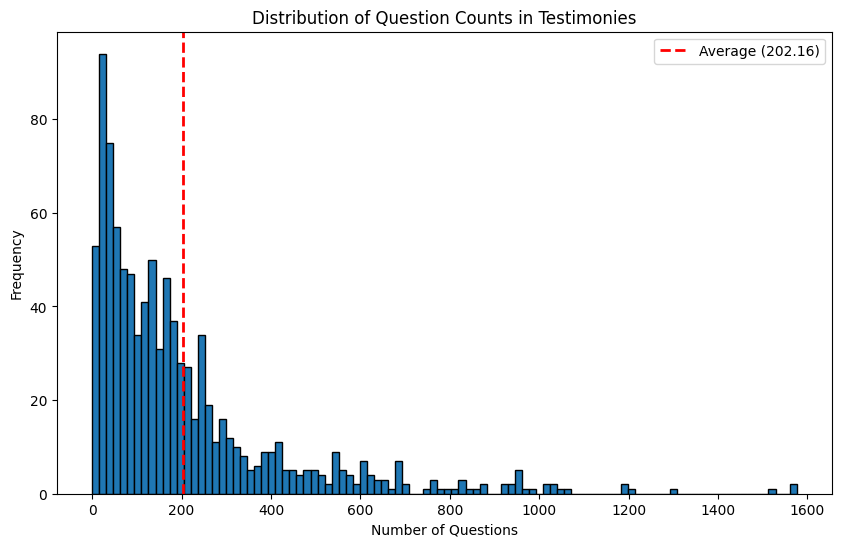

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(question_counts, bins=100, edgecolor='black')
plt.title('Distribution of Question Counts in Testimonies')
plt.xlabel('Number of Questions')
plt.ylabel('Frequency')
plt.axvline(avg_questions, color='r', linestyle='dashed', linewidth=2, label=f'Average ({avg_questions:.2f})')
plt.legend()
plt.show()

## Find Testimonies with Less than-n Testimonies

We can use this data to isolate the testimonies with less than a certain number of questions. These testimonies can be interesting, even though they represent a minority. Fewer questions can indicate two things. Either this can indicate a testimony that is shorter in nature or it can indicate a testimony where the interviewer allows the interviewee to speak for a longer portion of the interview.

In [57]:
less_than_n_questions = 10
testimonies_with_zero_questions = [
    item['rg'] for item, count in zip(full_dataset, question_counts) if count < less_than_n_questions
]

# Calculate the percentage of testimonies with 0 questions
percentage_zero_questions = (len(testimonies_with_zero_questions) / len(full_dataset)) * 100

print(f"\nPercentage of testimonies with less than {less_than_n_questions} questions: {percentage_zero_questions:.2f}%")
print(f"Number of testimonies with less than {less_than_n_questions} questions: {len(testimonies_with_zero_questions)}")
print("RG numbers of testimonies with less than {less_than_n_questions} questions:")
for rg in testimonies_with_zero_questions:
    print(rg)


Percentage of testimonies with less than 10 questions: 2.95%
Number of testimonies with less than 10 questions: 28
RG numbers of testimonies with less than {less_than_n_questions} questions:
RG-50.030.0313_trs_en_cleaned
RG-50.030.0312_trs_en_cleaned
RG-50.042.0003_trs_en_cleaned
RG-50.030.0308_trs_en_cleaned
RG-50.030.0230_trs_en_cleaned
RG-50.030.0424_trs_en_cleaned
RG-50.030.0317_trs_en_cleaned
RG-50.030.0080_trs_en_cleaned
RG-50.030.0300_trs_en_cleaned
RG-50.030.0304_trs_en_cleaned
RG-50.030.0355_trs_en_cleaned
RG-50.030.0258_trs_en_cleaned
RG-50.042.0027_trs_en_cleaned
RG-50.471.0003_trs_en_cleaned
RG-50.030.0194_trs_en_cleaned
RG-50.030.0011_trs_en_cleaned
RG-50.030.0012_trs_en_cleaned
RG-50.030.0216_trs_en_cleaned
RG-50.030.0170_trs_en_cleaned
RG-50.030.0138_trs_en_cleaned
RG-50.030.0532_trs_en_cleaned
RG-50.233.0058_trs_en_cleaned
RG-50.030.0534_trs_en_cleaned
RG-50.471.0016_trs_en_cleaned
RG-50.030.0338_trs_en_cleaned
RG-50.030.0126_trs_en_cleaned
RG-50.030.0322_trs_en_cleane

## Vectorize and Plot Questions

One of the most useful things we can do with this data, though, is to leverage machine learning. We can convert all our 200,000 questions. It is quite computationally expensive to do this in a single notebook and even more challenging to visualize this quantity of data here. Because of this, we will only work with a small subset of our data, the first 10 testimonies.

## Collect all the Questions

First, we need to isolate all the questions. We can do that with the following code snippet.

In [67]:
all_questions = []
rg_numbers = []
# Iterate through the dataset and print questions
for item in dataset.take(10):
    rg = item['rg']
    html_content = item['html']
    
    questions = extract_questions(html_content)
    all_questions.extend(questions)
    rg_numbers.extend([rg] * len(questions))

## Vectorize the Questions

Next, we can use a machine learning model via `SentenceTransformers` to vectorize all these questions.

In [64]:
# Initialize SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Vectorize the questions
question_embeddings = model.encode(all_questions, show_progress_bar=True)

/Applications/anaconda3/envs/fasthtml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Batches:   0%|          | 0/114 [00:00<?, ?it/s]

# Dimensionality Reduction

With these vectors created, we can now perform dimensionality reduction. Dimensionality reduction is a technique used to reduce the number of features in a dataset while retaining as much of the important information as possible. This process is particularly useful when dealing with high-dimensional data, such as the vector representations of our questions.

There are several reasons why dimensionality reduction is beneficial:

1. Visualization: It allows us to visualize high-dimensional data in 2D or 3D space, making it easier to identify patterns and clusters.

2. Computational Efficiency: Reducing the number of dimensions can significantly speed up machine learning algorithms and reduce memory usage.

3. Noise Reduction: It can help in removing noise from the data by focusing on the most important features.

4. Overcoming the Curse of Dimensionality: As the number of dimensions increases, the amount of data needed to make statistically sound predictions grows exponentially. Dimensionality reduction helps mitigate this issue.

In our case, we're using UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction. UMAP is a powerful technique that can capture both local and global structure in the data, making it particularly effective for visualizing complex datasets like our question embeddings.

By reducing our high-dimensional question embeddings to just two dimensions, we'll be able to create a scatter plot where each point represents a question. This visualization will allow us to see how questions relate to each other in semantic space, potentially revealing clusters of similar questions or other interesting patterns in the data.


In [71]:
# Reduce dimensions with UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.5, metric='cosine')
umap_embeddings = reducer.fit_transform(question_embeddings)

/Applications/anaconda3/envs/fasthtml/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Now we can bring all our data togegther in a single DataFrame. Think of a DataFrame, rather like an Excel spreadsheet. It's a way to visualize tabular data.

In [72]:
# Create a DataFrame for plotting
df = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Question': all_questions,
    'RG': rg_numbers  # Add the RG numbers to the DataFrame
})
df

,UMAP1,UMAP2,Question,RG
0,1.935546,1.239347,"Q: Good morning, Alice.",RG-50.030.0469_trs_en_cleaned
1,0.542093,-1.582287,"Q: Welcome, welcome to Washington, and Virginia.",RG-50.030.0469_trs_en_cleaned
2,-3.421229,2.924561,"Q: It's wonderful to have you here, finally, a...",RG-50.030.0469_trs_en_cleaned
3,2.784522,1.322130,"Q: Yes. Alice, tell me when you were born. Wha...",RG-50.030.0469_trs_en_cleaned
4,2.793391,1.620970,Q: And where were you born?,RG-50.030.0469_trs_en_cleaned
...,...,...,...,...
3633,1.044902,4.728747,Q: Never been there.,RG-50.549.02.0043_trs_en_cleaned
3634,-5.032952,5.916126,"Q: Mm-hm, yeah. Once is probably --",RG-50.549.02.0043_trs_en_cleaned
3635,0.213833,4.346578,Q: How was that?,RG-50.549.02.0043_trs_en_cleaned
3636,-1.663676,7.216995,"Q: Yeah. Well, I really thank you so much for ...",RG-50.549.02.0043_trs_en_cleaned


This shows us our x (UMAP1) and y (UMAP2) coordinates. It also shows us the question to which those coordinates belong and the specific filename (RG Number).

## Visualize the Results

We can use this data to visualize the results in an interactive plot. The code below creates a scatter plot using Plotly, a powerful library for interactive visualizations. Here's what the code does:

1. It creates a scatter plot using `px.scatter()` from Plotly Express.
2. The x and y coordinates are set to UMAP1 and UMAP2, which are our reduced dimensions.
3. Points are colored based on the RG number, allowing us to see if questions from the same interview cluster together.
4. Hover data is set to show the full question text and RG number when a user hovers over a point.
5. The plot is given a title and axis labels for clarity.
6. The size of the plot is adjusted for better visibility.
7. The hover template is customized to display information in a more readable format.
8. The layout is adjusted to ensure the plot uses the full available space.
9. A color bar title is added to explain what the colors represent.

This interactive visualization will allow us to explore the relationships between questions in a visual and intuitive way.

In [70]:
# Create an interactive scatter plot with Plotly
fig = px.scatter(
    df, x='UMAP1', y='UMAP2', 
    color='RG',  # Color points based on RG number
    hover_data=['Question', 'RG'],  # Include RG in hover data
    title='UMAP Visualization of Questions',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2', 'RG': 'RG Number'},
    height=800,  # Increased height to make the plot taller
    width=1000   # Adjusted width to maintain a good aspect ratio
)

# Update hover template to show full question text and RG number
fig.update_traces(
    hovertemplate='<b>Question:</b> %{customdata[0]}<br><b>RG Number:</b> %{customdata[1]}<extra></extra>'
)

# Update layout to ensure the plot uses the full space
fig.update_layout(
    autosize=False,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Add a color bar title
fig.update_coloraxes(colorbar_title='RG Number')

# Show the plot
fig.show()